In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

# Difference in the Terminal Output

For the same seed and settings two separate runs generate different outputs in the terminal;
the last line is different even though it seems the path is the same.

In [2]:
!cat cma.001.log

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=1, Fri May 16 11:18:59 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.325600000000000e+03 1.0e+00 2.66e-01  3e-01  3e-01 0:00.0
    2     16 5.000000000000000e+02 1.4e+00 2.98e-01  3e-01  3e-01 0:00.0
    3     24 4.940000000000000e+02 1.9e+00 2.84e-01  2e-01  3e-01 0:00.0
   21    168 5.000000000000000e+02 5.2e+00 3.31e-01  1e-01  2e-01 0:00.2
termination on tolflatfitness=1 (Fri May 16 11:18:59 2025)
final/bestever f-value = 5.000000e+02 4.916000e+02 after 169/133 evaluations
incumbent solution: [np.float64(0.9386043382115833), np.float64(0.4709626937078244), np.float64(0.021843081221268063), np.float64(0.08102816430804718), np.float64(0.762698209132451)]
std deviation: [np.float64(0.11381074980822264), np.float64(0.16939636259325588), np.float64(0.16367624473251036), np.float64(0.16040018865761171), np.float64(0.1613583735768437)]
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 5 (

In [3]:
!cat cma.002.log

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=1, Fri May 16 10:15:08 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.325600000000000e+03 1.0e+00 2.66e-01  3e-01  3e-01 0:00.1
    2     16 5.000000000000000e+02 1.4e+00 2.98e-01  3e-01  3e-01 0:00.1
    3     24 4.940000000000000e+02 1.9e+00 2.84e-01  2e-01  3e-01 0:00.1
   21    168 5.000000000000000e+02 5.2e+00 3.31e-01  1e-01  2e-01 0:00.3
termination on tolflatfitness=1 (Fri May 16 10:15:09 2025)
final/bestever f-value = 5.000000e+02 4.916000e+02 after 169/133 evaluations
incumbent solution: [np.float64(0.9386043382115833), np.float64(0.4709626937078244), np.float64(0.021843081221268063), np.float64(0.08102816430804718), np.float64(0.762698209132451)]
std deviation: [np.float64(0.11381074980822264), np.float64(0.16939636259325588), np.float64(0.16367624473251036), np.float64(0.16040018865761171), np.float64(0.1613583735768437)]
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 5 (

# Loading of my manual logging 
This logs the simulation calls, and for now also the penalty of the mixed constraint.

In [4]:
with open('./results/logging/1/evals.dat', 'r') as handle : lines = handle.readlines()

(mylog_fitness, mylog_constraint) = np.empty((2, len(lines)))
for (i, line) in enumerate(lines) : (mylog_fitness[i], mylog_constraint[i]) = map(float, line.split())
del lines

# Loading of the CMA-ES log files

In [5]:
header = 'iteration, evaluation, sigma, axis ratio, bestever, best, median, worst objective function value, interquartile range'
column_names = header.split(', ')

fit_logs = []
for i in (1, 2):
    fit = {c : [] for c in column_names}
    with open(f'./results/logging/{i}/outcmaes/fit.dat', 'r') as handle : 
        header = handle.readline()
        for line in handle :
            for (c, v) in zip(column_names, line.split()) :
                fit[c].append(float(v) if '.' in v else int(v))
    fit_logs.append(pd.DataFrame(fit))

fit_logs[0].head()

,iteration,evaluation,sigma,axis ratio,bestever,best,median,worst objective function value,interquartile range
0,1,8,0.265620,1.000040,2325.6,2325.6,70280.634720,90146.931830,54606.682962
1,2,16,0.297813,1.374551,500.0,500.0,29727.922061,65000.000000,27086.835327
2,3,24,0.283868,1.920709,494.0,494.0,9862.781132,40006.000000,22511.748784
3,4,32,0.335672,2.017275,494.0,500.0,9038.725267,38290.346349,18689.335955
4,5,40,0.373804,2.436793,492.8,492.8,500.000000,2898.213562,0.400000


In [6]:
(fit_logs[0] == fit_logs[1]).all().all()

True

Despite the difference in terminal output, the log files logging all iterations/generations are identical

In [7]:
fit = fit_logs[0]

In [8]:
with open('cma.001.log', 'r') as handle : lines = handle.readlines()

(start_index_1, start_index_2) = [i for (i, line) in enumerate(lines) if line.split()[0] == '1']
(terminal_evaluations, terminal_fitness) = zip(*[(int(line.split()[1]), float(line.split()[2])) for line in lines[start_index_2:-1]])

In [9]:
idx = [e in terminal_evaluations for e in fit['evaluation']]
fit_selection = fit.loc[idx, ['iteration', 'evaluation', 'best', 'bestever']]

fit_selection['terminal fitness'] = terminal_fitness

fit_selection

,iteration,evaluation,best,bestever,terminal fitness
21,1,186,8475.057748,8475.057748,8475.057748
22,2,203,489.600000,489.600000,489.600000
23,3,220,479.600000,479.600000,479.600000
62,42,883,0.090804,0.090804,0.090804
68,48,985,0.096234,0.087391,0.096234
73,53,1070,0.088048,0.087391,0.088048
79,59,1172,0.084842,0.083944,0.084842
86,66,1291,0.083874,0.083806,0.083874
94,74,1427,0.083512,0.083512,0.083512
101,81,1546,0.083669,0.083512,0.083669


# Checking agreement between my logs and the CMA logs

In [10]:
# starting from after the restart
start_index_2_df = np.argwhere((fit['iteration'] == 1).values)[1,0]

(cmalog_evaluations, cmalog_bestever) = fit.iloc[start_index_2_df:][['evaluation', 'bestever']].values.T

In [11]:
# picking up the same evaluations found as in the cma-log, note this is once per generation
mylog_bestever = np.minimum.accumulate(mylog_fitness)[cmalog_evaluations.astype(int)-1]

In [12]:
np.allclose(mylog_bestever[1:], cmalog_bestever[1:])

True

They're the same with the exception of the first generation, the `mylog_fitness` uses the min from the previous run as it doesn't recognize the restart.

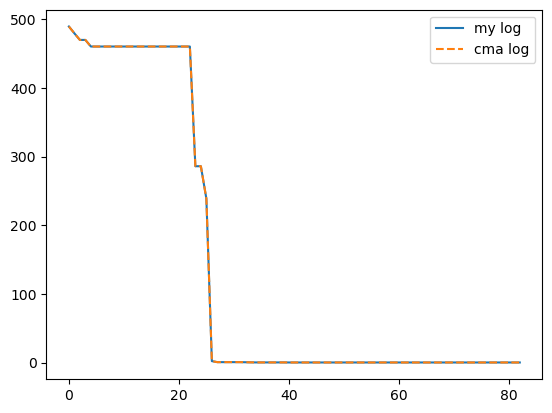

In [13]:
plt.plot(mylog_bestever[1:], label='my log')
plt.plot(cmalog_bestever[1:], ls='--', label='cma log')
plt.legend()